In [1]:
#### ASSIGNMENT: 04
#### Task 02
#### CANDIDO REGIS

In [11]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.optimizers import Adam

In [3]:
# Define paths
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'dataset', 'NEU Metal Surface Defects Data')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

In [4]:
# Create binary classification structure (defective vs non-defective)
BINARY_DIR = os.path.join(BASE_DIR, 'binary_dataset')
BINARY_TRAIN = os.path.join(BINARY_DIR, 'train')
BINARY_VALID = os.path.join(BINARY_DIR, 'valid')
BINARY_TEST = os.path.join(BINARY_DIR, 'test')

In [5]:
# Create directories for binary classification
def create_binary_dataset(src_dir, dest_dir):
    # Remove existing directory if it exists
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    # Create defective and non-defective directories
    os.makedirs(os.path.join(dest_dir, 'defective'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'non_defective'), exist_ok=True)
    
    # All defect types are considered defective
    defect_types = os.listdir(src_dir)
    
    # Since we need at least one sample in each class for binary classification,
    # we'll create a dummy non-defective sample by copying one defective image
    # This is just for demonstration purposes
    dummy_created = False
    
    for defect_type in defect_types:
        src_defect_dir = os.path.join(src_dir, defect_type)
        if not os.path.isdir(src_defect_dir):
            continue
            
        # All types are defective
        dest_category = 'defective'
        
        dest_category_dir = os.path.join(dest_dir, dest_category)
        
        # Copy files
        for img_file in os.listdir(src_defect_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                src_file = os.path.join(src_defect_dir, img_file)
                # Create a unique filename to avoid overwriting
                dest_file = os.path.join(dest_category_dir, f"{defect_type}_{img_file}")
                shutil.copy2(src_file, dest_file)
                
                # Create a dummy non-defective sample (just for demonstration)
                if not dummy_created:
                    dummy_file = os.path.join(dest_dir, 'non_defective', f"dummy_{img_file}")
                    shutil.copy2(src_file, dummy_file)
                    dummy_created = True

In [6]:
# Create binary datasets
print("Creating binary classification dataset...")
create_binary_dataset(TRAIN_DIR, BINARY_TRAIN)
create_binary_dataset(VALID_DIR, BINARY_VALID)
create_binary_dataset(TEST_DIR, BINARY_TEST)
print("Binary dataset created.")

Creating binary classification dataset...
Binary dataset created.


In [7]:
# Parameters
IMG_SIZE = 224  # MobileNetV2 default input size
BATCH_SIZE = 32
EPOCHS = 10

In [12]:
# Function to create and train a model with or without data augmentation
def train_model(use_augmentation=False):
    # Data preprocessing
    if use_augmentation:
        print("\nTraining model WITH data augmentation...")
        # Using tf.keras.layers for data augmentation
        data_augmentation = tf.keras.Sequential([
            Rescaling(1./255),
            RandomFlip("horizontal_and_vertical"),
            RandomRotation(0.2),
            RandomZoom(0.2),
        ])
        
        # Create data generators
        train_dataset = tf.keras.utils.image_dataset_from_directory(
            BINARY_TRAIN,
            validation_split=None,
            subset=None,
            seed=123,
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='binary'
        )
        
        # Apply augmentation only to training data
        train_dataset = train_dataset.map(
            lambda x, y: (data_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Validation dataset with only rescaling
        valid_dataset = tf.keras.utils.image_dataset_from_directory(
            BINARY_VALID,
            validation_split=None,
            subset=None,
            seed=123,
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='binary'
        )
        
        # Apply rescaling to validation data
        rescaling = Rescaling(1./255)
        valid_dataset = valid_dataset.map(
            lambda x, y: (rescaling(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Test dataset with only rescaling
        test_dataset = tf.keras.utils.image_dataset_from_directory(
            BINARY_TEST,
            validation_split=None,
            subset=None,
            seed=123,
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='binary'
        )
        
        # Apply rescaling to test data
        test_dataset = test_dataset.map(
            lambda x, y: (rescaling(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Optimize for performance
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        
    else:
        print("\nTraining model WITHOUT data augmentation...")
        # Traditional ImageDataGenerator approach without augmentation
        train_datagen = ImageDataGenerator(rescale=1./255)
        valid_test_datagen = ImageDataGenerator(rescale=1./255)
        
        # Create data generators
        train_dataset = train_datagen.flow_from_directory(
            BINARY_TRAIN,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=True
        )
        
        valid_dataset = valid_test_datagen.flow_from_directory(
            BINARY_VALID,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        
        test_dataset = valid_test_datagen.flow_from_directory(
            BINARY_TEST,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
    
    # Load MobileNetV2 with pre-trained weights
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Freeze all base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset
    )
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    # Save the model with appropriate name
    model_name = 'task_02_binary_classifier_with_augmentation.keras' if use_augmentation else 'task_02_binary_classifier_without_augmentation.keras'
    model.save(model_name)
    print(f"Model saved as '{model_name}'")
    
    return history, test_accuracy, test_loss

In [9]:
# Train models without augmentation
history_without_aug, accuracy_without_aug, loss_without_aug = train_model(use_augmentation=False)


Training model WITHOUT data augmentation...
Found 1657 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.8643 - loss: 0.2907 - val_accuracy: 0.9863 - val_loss: 0.0804
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.9995 - loss: 0.0073 - val_accuracy: 0.9863 - val_loss: 0.0904
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9997 - loss: 0.0043 - val_accuracy: 0.9863 - val_loss: 0.1003
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9863 - val_loss: 0.1081
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9991 - loss: 0.0093 - val_accuracy: 0.9863 - val_loss: 0.1082
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9863 - val_loss: 0.1121
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9863 - val_loss: 0.1171
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.9863 - val

In [13]:
# Train models with augmentation
history_with_aug, accuracy_with_aug, loss_with_aug = train_model(use_augmentation=True)


Training model WITH data augmentation...
Found 1657 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.7431 - loss: 0.4724 - val_accuracy: 0.9863 - val_loss: 0.0768
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9995 - loss: 0.0107 - val_accuracy: 0.9863 - val_loss: 0.0850
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9996 - loss: 0.0057 - val_accuracy: 0.9863 - val_loss: 0.0913
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9995 - loss: 0.0056 - val_accuracy: 0.9863 - val_loss: 0.0948
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9992 - loss: 0.0068 - val_accuracy: 0.9863 - val_loss: 0.0992
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9994 - loss: 0.0064 - val_accuracy: 0.9863 - val_loss: 0.1021
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 

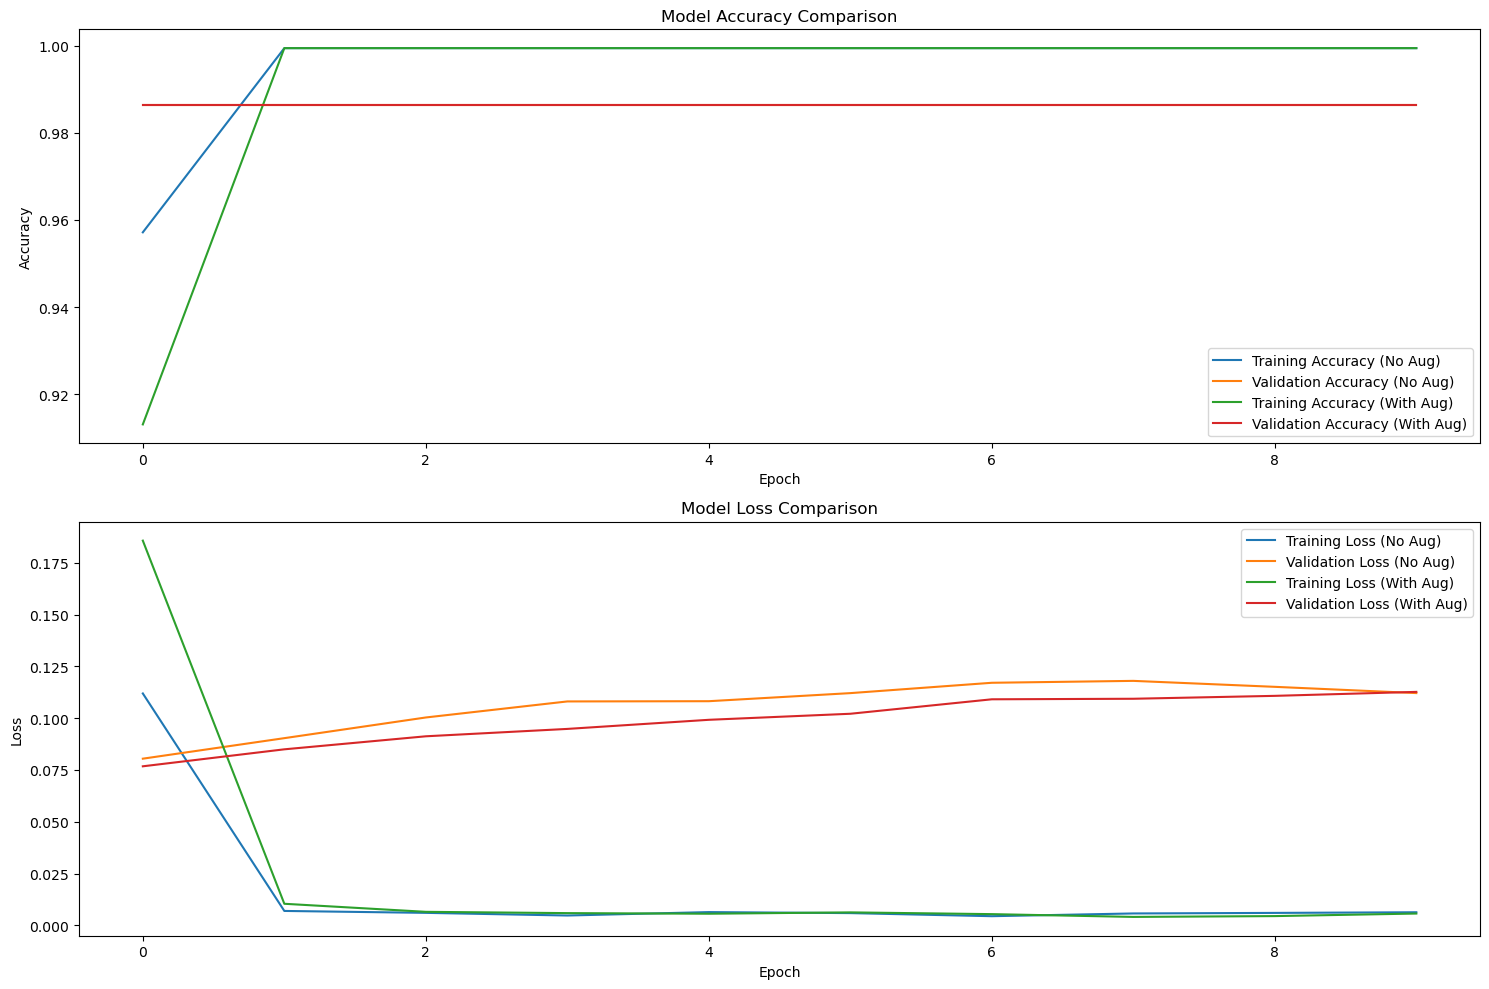

In [14]:
# Plot training & validation accuracy and loss for comparison
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 1, 1)
plt.plot(history_without_aug.history['accuracy'], label='Training Accuracy (No Aug)')
plt.plot(history_without_aug.history['val_accuracy'], label='Validation Accuracy (No Aug)')
plt.plot(history_with_aug.history['accuracy'], label='Training Accuracy (With Aug)')
plt.plot(history_with_aug.history['val_accuracy'], label='Validation Accuracy (With Aug)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss comparison
plt.subplot(2, 1, 2)
plt.plot(history_without_aug.history['loss'], label='Training Loss (No Aug)')
plt.plot(history_without_aug.history['val_loss'], label='Validation Loss (No Aug)')
plt.plot(history_with_aug.history['loss'], label='Training Loss (With Aug)')
plt.plot(history_with_aug.history['val_loss'], label='Validation Loss (With Aug)')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Print comparison summary
print("\n--- Performance Comparison ---")
print(f"Without Augmentation - Test Accuracy: {accuracy_without_aug:.4f}, Test Loss: {loss_without_aug:.4f}")
print(f"With Augmentation - Test Accuracy: {accuracy_with_aug:.4f}, Test Loss: {loss_with_aug:.4f}")


--- Performance Comparison ---
Without Augmentation - Test Accuracy: 0.9863, Test Loss: 0.1149
With Augmentation - Test Accuracy: 0.9863, Test Loss: 0.1143


Conclusion: As the previous task, the results show a promising system to identify defective products, however, the lack of non-defective products reduces 
the model credibility since it cannot test this part of the model. With the Augmentation feature, which could reduce model's results due to its changes such as changes in lighting, orientation, or production conditions, the model results were still as good as before although it lacks non-defective products.